# Time Series Analysis (Temperature Forcast Tempelhof): 
In this project, you analyse temperature time series from  Berlin Tempelhof and we create a short-term temperature forecast for Berlin Tempelhof.
- Get and clean temperature data from www.ecad.eu
- Build a baseline model for trend + Plot and inspect
- Build a baseline model for seasonality + Plot and inspect
- Extract the remainder + Test the remainder for stationarity
- Model time dependence of the remainder using an AR model
- Compare the statistical output of different AR models
- Model Validation: Cross-Validation + Split train - test
- Predicting Temperature for the after. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (14,6)

Loading data

In [2]:
path = "data/berlin_tempel_mean_ecad/ECA_blended_custom1/TG_STAID002759"
df = pd.read_csv(path+".txt",skiprows=19, parse_dates=[1])

Change column names

In [3]:
df = df.drop(columns = [' SOUID'])
df.columns = ['date','temp', 'quality']
df

,date,temp,quality
0,1876-01-01,22,0
1,1876-01-02,25,0
2,1876-01-03,3,0
3,1876-01-04,-58,0
4,1876-01-05,-98,0
...,...,...,...
53867,2023-06-26,223,0
53868,2023-06-27,169,0
53869,2023-06-28,183,0
53870,2023-06-29,207,0


Define new columns for day, month, day365 (which day in year) and tempC (correct temperature, that is temp/10)

In [4]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day365'] = df['date'].dt.day_of_year
df['tempC'] = df['temp']/10
df

,date,temp,quality,day,month,day365,tempC
0,1876-01-01,22,0,1,1,1,2.2
1,1876-01-02,25,0,2,1,2,2.5
2,1876-01-03,3,0,3,1,3,0.3
3,1876-01-04,-58,0,4,1,4,-5.8
4,1876-01-05,-98,0,5,1,5,-9.8
...,...,...,...,...,...,...,...
53867,2023-06-26,223,0,26,6,177,22.3
53868,2023-06-27,169,0,27,6,178,16.9
53869,2023-06-28,183,0,28,6,179,18.3
53870,2023-06-29,207,0,29,6,180,20.7


A function to plot 2 columns of df, esp temperature as a function of date

In [5]:
def plot_temp(df, title='temperature',ylim = True):
    df.plot()
    plt.title(title)
    plt.ylabel('temperature')
    if ylim:
        plt.ylim(ymin=-10)
    plt.show()

Plotting temp as a function of date and Looking at missing data

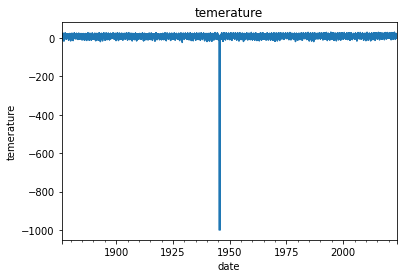

In [6]:
plot_temp(df.set_index('date')['tempC'], title='temperature',ylim = False)

In [7]:
df_missing = df[df['quality']==9]
first_missD = df_missing['date'].min()
last_missD = df_missing['date'].max()
df_missing['temp'].count(), first_missD, last_missD, (last_missD-first_missD)

(195,
 Timestamp('1945-04-25 00:00:00'),
 Timestamp('1945-11-05 00:00:00'),
 Timedelta('194 days 00:00:00'))

195 days are missed, here we define a function that fills the missed dates by the average temperature of the same day in last and the next year

In [8]:
ref_years = [-1,1]
def clean_temp(df,x): 
    
    if x['quality']==9: 
        for y in ref_years:
            ref_dates = [x['date']+relativedelta(years=y)]  
            ref_temp_value = int(df[df['date'].isin(ref_dates)]['tempC'].mean())
            return ref_temp_value 
    return x['tempC'] 

In [9]:
#filling missed dates by the average temperature of the same day in last and the next year
df['clean_temp'] = df.apply(lambda x: clean_temp(df,x), axis=1)

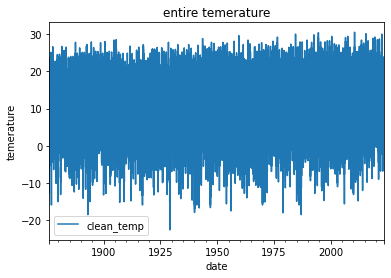

In [10]:
#Plot the clean temperature to check if the filling procedure worked correctly?
plot_temp(df.set_index('date')[['clean_temp']], title='entire temperature',ylim = False)

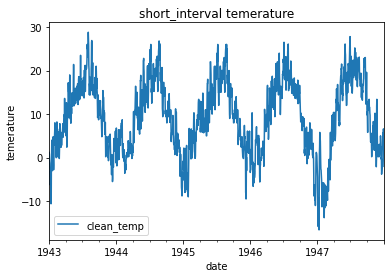

In [11]:
# Zooming in for the missed interval '1945-04-25':'1945-11-05'
plot_temp(df.set_index('date')[['clean_temp']]['1943-01-01':'1947-12-31'], title='short_interval temperature',ylim = False)

# Trend
To find the 'trend' in our temperature time series using LinearRegression, we generate timestep as a new column:

In [14]:
df['timestep'] = list(range(len(df)))

Trend: Train the temperature time series using LinearRegression() and plot the trend.

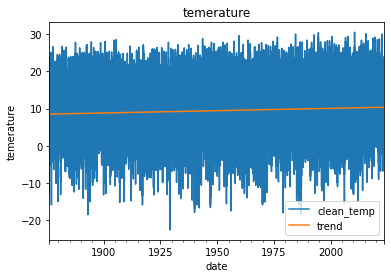

In [15]:
X = df[['timestep']]
y = df['clean_temp']

lr_trend = LinearRegression()
lr_trend.fit(X, y)
df['trend'] = lr_trend.predict(X)
plot_temp(df.set_index('date')[['clean_temp','trend']], title='temperature',ylim = False)


As temperature has a yearly (seasonal) pattern patter, over >100 years using only trend is not enough to describe the temperature behavior. So we make dummy variables of month and day365 to check which one works better for finding sesonal pattern?!

# Seasonality

In [16]:
# Transform month and day365 To categorical variables to be suitable for LinearReg: 
seasonal_dummies = pd.get_dummies(df['month'],
                                  prefix='month',
                                  drop_first=True).set_index(df.index)

seasonal_dummiesD = pd.get_dummies(df['day365'],
                                  prefix='day',
                                  drop_first=True).set_index(df.index)

df = pd.concat([df, seasonal_dummies,seasonal_dummiesD], axis = 1)
df


,date,temp,quality,day,month,day365,tempC,clean_temp,timestep,trend,...,day_357,day_358,day_359,day_360,day_361,day_362,day_363,day_364,day_365,day_366
0,1876-01-01,22,0,1,1,1,2.2,2.2,0,8.510696,...,False,False,False,False,False,False,False,False,False,False
1,1876-01-02,25,0,2,1,2,2.5,2.5,1,8.510731,...,False,False,False,False,False,False,False,False,False,False
2,1876-01-03,3,0,3,1,3,0.3,0.3,2,8.510765,...,False,False,False,False,False,False,False,False,False,False
3,1876-01-04,-58,0,4,1,4,-5.8,-5.8,3,8.510799,...,False,False,False,False,False,False,False,False,False,False
4,1876-01-05,-98,0,5,1,5,-9.8,-9.8,4,8.510833,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53867,2023-06-26,223,0,26,6,177,22.3,22.3,53867,10.351426,...,False,False,False,False,False,False,False,False,False,False
53868,2023-06-27,169,0,27,6,178,16.9,16.9,53868,10.351460,...,False,False,False,False,False,False,False,False,False,False
53869,2023-06-28,183,0,28,6,179,18.3,18.3,53869,10.351494,...,False,False,False,False,False,False,False,False,False,False
53870,2023-06-29,207,0,29,6,180,20.7,20.7,53870,10.351528,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Make a list of features which are going to be used for training in the next step
month_dummy_features = []
day_dummy_features = []
for j in range(2,13): month_dummy_features.append(f'month_{j}')
for j in range(2,366): day_dummy_features.append(f'day_{j}')

Then we train "Seasonality" using :
- dummy months
- dummy day365
- dummy months + dummy day365
and LinearRegression() and compare the result. Which one works better? 

Training with trend + month seasonality -> score: 0.75118
Training with trend + day365 seasonality -> score:  0.76968
Training with trend + month & day365 seasonality -> score:   0.76969


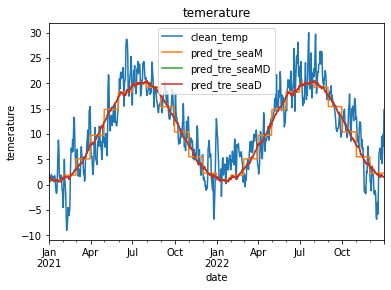

In [18]:
y = df['clean_temp']

X = df[['timestep']+month_dummy_features]
lr_tre_seaM = LinearRegression()
lr_tre_seaM.fit(X, y)
print(f'Training with trend + month seasonality -> score: {round(lr_tre_seaM.score(X, y),5)}')
df['pred_tre_seaM'] = lr_tre_seaM.predict(X)

X = df[['timestep']+day_dummy_features]
lr_tre_seaD = LinearRegression()
lr_tre_seaD.fit(X, y)
print(f'Training with trend + day365 seasonality -> score:  {round(lr_tre_seaD.score(X, y),5)}')
df['pred_tre_seaD'] = lr_tre_seaD.predict(X)

X = df[['timestep']+month_dummy_features+day_dummy_features]
lr_tre_seaMD = LinearRegression()
lr_tre_seaMD.fit(X, y)
print(f'Training with trend + month & day365 seasonality -> score:   {round(lr_tre_seaMD.score(X, y),5)}')
df['pred_tre_seaMD'] = lr_tre_seaMD.predict(X)

plot_temp(df.set_index('date')[['clean_temp','pred_tre_seaM','pred_tre_seaMD','pred_tre_seaD']]['2021-01-01':'2022-12-31'], title='temperature',ylim = False)


Using day365 dummis for training seems to be better for training. Not uch difference when adding month dummy to it!  

# Remainer
To improve the training we use remainder of the temperature of our prediction from real temperature in the previous step, so we calculate remainder and and .shift(1) and define lag1. 

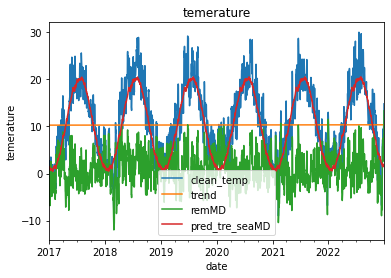

In [19]:
df['remMD'] = df['clean_temp'] - df['pred_tre_seaMD']
df['lag1MD'] = df['remMD'].shift(1)

df['remD'] = df['clean_temp'] - df['pred_tre_seaD']
df['lag1D'] = df['remD'].shift(1)

df['remM'] = df['clean_temp'] - df['pred_tre_seaM']
df['lag1M'] = df['remM'].shift(1)

plot_temp(df.set_index('date')[['clean_temp','trend','remMD','pred_tre_seaMD']]['2017-01-01':'2022-12-31'], title='temperature',ylim = False)

#### Check if remainder is stationary using Augmented Dickey-Fuller test (adfuller function):
We need to make sure that the remainders exhibits no trends, seasonality, or other patterns that may lead to biased model predictions. A stationary remainder implies that the model has adequately captured the underlying patterns, leaving behind mostly random fluctuations.

In [20]:
from statsmodels.tsa.stattools import adfuller

def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test in a more pretty way"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,4)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],4)} (p < 0.01; CI = 99%) 
            {round(levels['5%'],4)} (p < 0.05; CI = 95%)
            {round(levels['10%'],4)} (p < 0.1 CI = 90%) 
            information criterion (AIC): {information_criterion}
            """) 

In [21]:
print_adf(df['remMD'])

   
            adf: -38.3968
            p: 0.0 
            used lag: 21 
            number of observations: 53850
            -3.4305 (p < 0.01; CI = 99%) 
            -2.8616 (p < 0.05; CI = 95%)
            -2.5668 (p < 0.1 CI = 90%) 
            information criterion (AIC): 238750.6212430148
            


The more negative adf, the stronger the evidence against the null hypothesis. Considering p-value = 0.05, we have -38.3932 < -2.8616 which helps rejecting the null Hypothesis: "The remainder is not stationary"

How any lags to use? For this we need to calculate correlation or easier we can use 'plot_pacf;

In [22]:
df['lag2MD'] = df['remMD'].shift(2)
round(df[['remMD', 'lag1MD', 'lag2MD']].corr(), 2)

,remMD,lag1MD,lag2MD
remMD,1.0,0.8,0.6
lag1MD,0.8,1.0,0.8
lag2MD,0.6,0.8,1.0


In [23]:
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(df['remMD'])
# plt.xlabel('lags');

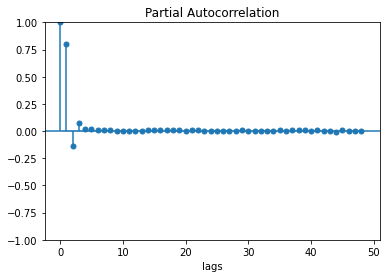

In [24]:
# plot partial autocorrelation function: Statsmodels provides a function called plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['remMD'])
plt.xlabel('lags');

plot_pacf shows only lag1 is enough

#### AutoRegressive Model: Trend + Seasonality + Remainder

 AR with timestep + month + day365 dummies :  0.91806337
 AR with timestep + day365 dummies :  0.91807351
 AR with timestep + month dummies :  0.91739779


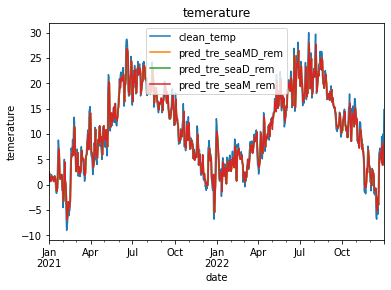

In [25]:
df.dropna(inplace = True)
y = df['clean_temp']

X = df[['timestep']+month_dummy_features+day_dummy_features+['lag1MD']]
lr_tre_seaMD = LinearRegression()
lr_tre_seaMD.fit(X, y)
df['pred_tre_seaMD_rem'] = lr_tre_seaMD.predict(X)
print(f' AR with timestep + month + day365 dummies :  {round(lr_tre_seaMD.score(X, y),8)}')

X = df[['timestep']+month_dummy_features+day_dummy_features+['lag1D']]
lr_tre_seaD = LinearRegression()
lr_tre_seaD.fit(X, y)
df['pred_tre_seaD_rem'] = lr_tre_seaD.predict(X)
print(f' AR with timestep + day365 dummies :  {round(lr_tre_seaD.score(X, y),8)}')

X = df[['timestep']+month_dummy_features+day_dummy_features+['lag1M']]
lr_tre_seaM = LinearRegression()
lr_tre_seaM.fit(X, y)
df['pred_tre_seaM_rem'] = lr_tre_seaM.predict(X)
print(f' AR with timestep + month dummies :  {round(lr_tre_seaM.score(X, y),8)}')


plot_temp(df.set_index('date')[['clean_temp','pred_tre_seaMD_rem','pred_tre_seaD_rem','pred_tre_seaM_rem']]['2021-01-01':'2022-12-31'], title='temperature',ylim = False)

after lag1, not too much difference if including day dummies too! lag1 can correct the step-shape prediction of seasonal! 

### Trying with built-in AutoReg function in statsmodels.tsa

Using AutoReg on df['remainderMD'] on whole data

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


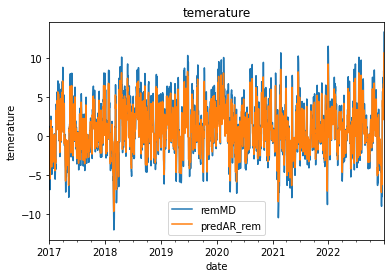

In [26]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df['remMD'], lags=1).fit()
df['predAR_rem'] = ar_model.predict(start=0, end=len(df)+2, dynamic=False)

plot_temp(df.set_index('date')[['remMD','predAR_rem']]['2017-01-01':'2022-12-31'], title='temperature',ylim = False)
# ar_model.summary()


In [27]:
df['PredAR_all'] = df['predAR_rem'] + df['pred_tre_seaMD']

print(f" LR trend, seasonal, lag1 (previous result) score:    {round(r2_score(df['clean_temp'], df['pred_tre_seaMD_rem']),8)}")
print(f"                                    AutoReg score:    {round(r2_score(df['clean_temp'], df['PredAR_all']),8)}")

 LR trend, seasonal, lag1 (previous result) score:    0.91806337
                                    AutoReg score:    0.91805574


# ARIMA

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


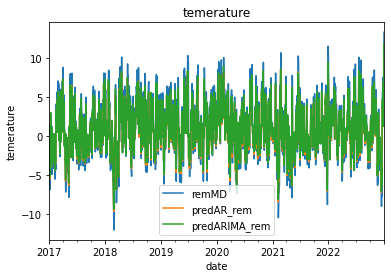

 LR trend, seasonal, lag1 (previous result) score:    0.91806337
                                    AutoReg score:    0.91805574
                                      ARIMA score:    0.89396762


In [37]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['remMD'], order = (1,1,3)).fit()


df['predARIMA_rem'] = arima_model.predict(start=0, end=len(df)+2, dynamic=False)


plot_temp(df.set_index('date')[['remMD','predAR_rem','predARIMA_rem']]['2017-01-01':'2022-12-31'], title='temperature',ylim = False)

df['PredARIMA_all'] = df['predARIMA_rem'] + df['pred_tre_seaMD']

print(f" LR trend, seasonal, lag1 (previous result) score:    {round(r2_score(df['clean_temp'], df['pred_tre_seaMD_rem']),8)}")
print(f"                                    AutoReg score:    {round(r2_score(df['clean_temp'], df['PredAR_all']),8)}")
print(f"                                      ARIMA score:    {round(r2_score(df['clean_temp'], df['PredARIMA_all']),8)}")

# Model Validation: Split train - test

In [28]:
df_bk = df[['date','clean_temp','timestep']+day_dummy_features+month_dummy_features]

df_train = pd.DataFrame()
df_test = pd.DataFrame()


 train score before lag1:     0.76934
   train score with lag1:     0.91795


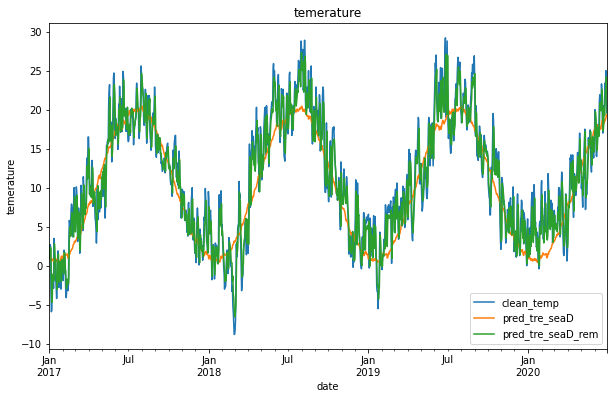

In [43]:
df_train = df_bk[df_bk['date']<='2020-06-30']

X_train = df_train[['timestep']+day_dummy_features]
y_train = df_train['clean_temp']

lr_tt_seasonal = LinearRegression()
lr_tt_seasonal.fit(X_train, y_train)
df_train['pred_tre_seaD'] = lr_tt_seasonal.predict(X_train)
print(f' train score before lag1:     {round(lr_tt_seasonal.score(X_train, y_train),5)}')
# --------------------
df_train['remD'] = df_train['clean_temp'] - df_train['pred_tre_seaD']
df_train['lag1'] = df_train['remD'].shift(1)

df_train.dropna(inplace = True)

X_train_lag1 = df_train[['timestep']+day_dummy_features+['lag1']]
y_train_lag1 = df_train['clean_temp']

lr_tt_seasonal_rem = LinearRegression()
lr_tt_seasonal_rem.fit(X_train_lag1, y_train_lag1)
df_train['pred_tre_seaD_rem'] = lr_tt_seasonal_rem.predict(X_train_lag1)
print(f'   train score with lag1:     {round(lr_tt_seasonal_rem.score(X_train_lag1, y_train_lag1),5)}')

plot_temp(df_train.set_index('date')[['clean_temp','pred_tre_seaD','pred_tre_seaD_rem']]['2017-01-01':'2020-06-30'], title='temperature',ylim = False)

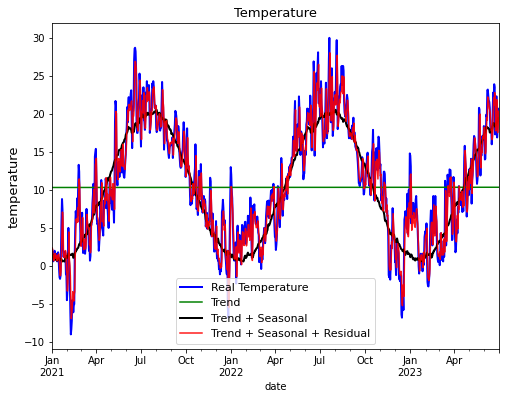

In [79]:
# A plot for presentation
title='Temperature'
ax = df.set_index('date')[['clean_temp','trend','pred_tre_seaD','pred_tre_seaD_rem']]['2021-01-01':'2023-06-30'].plot(color=['blue', 'green','black','red'])#, alpha=[0.2,1])
lines = ax.get_lines()

lines[0].set_alpha(1)
lines[0].set_linewidth(2)

lines[2].set_linewidth(2)

lines[3].set_alpha(0.9)

ax.set_title(title,fontsize = 13)
ax.set_ylabel('temperature',fontsize = 13)
ax.legend(['Real Temperature','Trend','Trend + Seasonal','Trend + Seasonal + Residual'],fontsize = 11)
plt.savefig('Temperature_Prediction.png',dpi = 300)
plt.savefig('Temperature_Prediction.pdf',dpi = 300)


Cross-validation

In [30]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=10)

# Split the training data into folds
# for i, (train_index, validation_index) in enumerate(ts_split.split(X_train, y_train)):
#     print(f"""The training data for the {i+1}th iteration are the observations steps 
#     {train_index}""")
#     print(f"""The validation data for the {i+1}th iteration are the observations steps
#     {validation_index}""")
#     print('\n')

# Cross Validation:
# Create the time series split
time_series_split = ts_split.split(X_train_lag1, y_train_lag1) 

# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=lr_tt_seasonal_rem, 
                         X=X_train_lag1, y=y_train_lag1,
                         cv=time_series_split)
result

array([0.91869332, 0.90775901, 0.89770113, 0.91564997, 0.91954736,
       0.91510296, 0.91567669, 0.90963645, 0.91754631, 0.92267514])

  test score before lag1:     0.77172
    test score with lag1:     0.91897


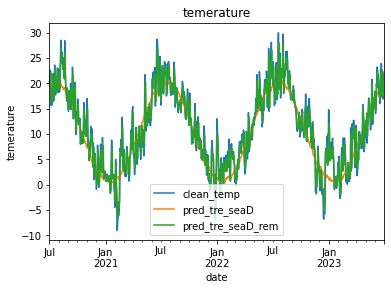

In [31]:
df_test= df_bk[df_bk['date']>'2020-06-30']

X_test = df_test[['timestep']+day_dummy_features]
y_test = df_test['clean_temp']

df_test['pred_tre_seaD'] = lr_tt_seasonal.predict(X_test)
print(f'  test score before lag1:     {round(lr_tt_seasonal.score(X_test, y_test),5)}')
# --------------------
df_test['remD'] = df_test['clean_temp'] - df_test['pred_tre_seaD']
df_test['lag1'] = df_test['remD'].shift(1)
df_test.loc[52777,'lag1'] = df_train.loc[52776,'remD']

X_test_lag1 = df_test[['timestep']+day_dummy_features+['lag1']]
y_test_lag1 = df_test['clean_temp']

df_test['pred_tre_seaD_rem'] = lr_tt_seasonal_rem.predict(X_test_lag1)
print(f'    test score with lag1:     {round(lr_tt_seasonal_rem.score(X_test_lag1, y_test_lag1),5)}')

plot_temp(df_test.set_index('date')[['clean_temp','pred_tre_seaD','pred_tre_seaD_rem']]['2020-06-30':], title='temperature',ylim = False)

# Forcasting:

 Temperature for next day (2023-07-01 00:00:00)  -->  19.176664418135424


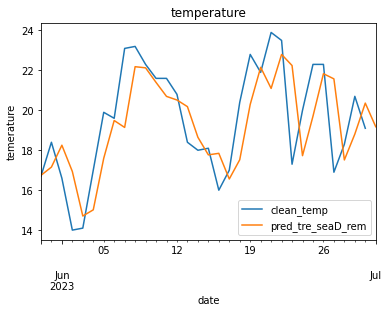

In [32]:
numDs_forcast = 1
df_total = pd.concat([df_train,df_test],axis = 0)
df_forcast_total = pd.DataFrame(columns = ['date','timestep']+day_dummy_features+['pred_tre_seaD','pred_tre_seaD_rem','lag1','remD'])
last_index = 53871
import datetime

for i in range(0,numDs_forcast):
    df_forcast_tomorrow = pd.DataFrame(columns = ['date','timestep']+day_dummy_features+['pred_tre_seaD','pred_tre_seaD_rem','lag1','remD'])

    timestep = df_total['timestep'].max() + 1
    tomorrow_date = df_total['date'].max() + datetime.timedelta(days=1)

    # month = tomorrow_date.month
    # month_list = [0]*11
    # month_list[month-2] = 1
    # month_dict = dict(zip(month_dummy_features, month_list))


    day = tomorrow_date.day_of_year
    day_list = [0]*364
    day_list[day-2] = 1
    day_dict = dict(zip(day_dummy_features, day_list))


    tomorrow = {'date':tomorrow_date,'timestep':timestep, 'lag1':df_total.loc[last_index,'remD']}
    tomorrow.update(day_dict)
    last_index = last_index +1
    row = pd.Series(tomorrow, name = last_index)
    df_forcast_tomorrow = df_forcast_tomorrow._append(row)

    X_future = df_forcast_tomorrow[['timestep']+day_dummy_features]
    X_future_lag1 = df_forcast_tomorrow[['timestep']+day_dummy_features+['lag1']]

    df_forcast_tomorrow['pred_tre_seaD'] = lr_tt_seasonal.predict(X_future)
    df_forcast_tomorrow['pred_tre_seaD_rem'] = lr_tt_seasonal_rem.predict(X_future_lag1)
    df_forcast_tomorrow['remD'] = df_forcast_tomorrow['pred_tre_seaD_rem'] - df_forcast_tomorrow['pred_tre_seaD']
    df_total = pd.concat([df_total,df_forcast_tomorrow], axis = 0)

    Temp = df_forcast_tomorrow.loc[last_index,'pred_tre_seaD_rem']
    print(f' Temperature for next day ({tomorrow_date})  -->  {Temp}')

plot_temp(df_total.set_index('date')[['clean_temp','pred_tre_seaD_rem']]['2023-05-30':], title='temperature',ylim = False)

